# ElasticNet StandardScaler Grid model

#### 1. 준비

In [1]:
# 관련 라이브러리 및 모듈 Import
# import
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import SGDRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
def evaluate_score(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f'mse- {mse:.3f}')
    print(f'rmse- {rmse:.3f}')
    print(f'r2- {r2:.3f}')
    
    return

### 데이터 수집, 탐색, 준비

####  데이터셋에 대한 설명 및 정보 확인

In [4]:
# 데이터 csv 불러오기
train = pd.read_csv('./train5.csv')

In [5]:
# X(독립변수), Y(종속변수) 분할
X = train.drop('match', axis=1)
y = train['match']
# 학습용 데이터와 평가용 데이터로 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### SGDRegressor의 엘라스틱넷규제 모델 scaling, GridSerchCV

In [6]:
# 데이터셋을 훈련용과 테스트용으로 분리
X = train.drop('match', axis=1)
y = train['match']
# 학습용 데이터와 평가용 데이터로 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 모델 파이프라인 생성
model = make_pipeline(
    StandardScaler(),
    SGDRegressor(loss='squared_error', penalty='elasticnet', random_state=42)
)

# GridSearchCV를 사용하여 하이퍼파라미터 튜닝
param_grid = {
    'sgdregressor__alpha': [0.001, 0.01, 0.9, 1, 10, 100],
    'sgdregressor__l1_ratio': [0.01, 0.1, 0.15, 0.5, 0.75, 0.9],
    'sgdregressor__max_iter': [1, 50, 100],
}

# 그리드 서치 객체 생성
grid = GridSearchCV(model, param_grid, cv=5)

# 모델 학습
grid.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best parameters: ", grid.best_params_)

# 최적의 모델 선택
best_model = grid.best_estimator_

# 예측
y_pred = best_model.predict(X_test)
y_pred[y_pred < 0] = 0.

# 최적의 모델로 성능 평가
evaluate_score(y_test, y_pred)

Best parameters:  {'sgdregressor__alpha': 0.9, 'sgdregressor__l1_ratio': 0.01, 'sgdregressor__max_iter': 50}
mse- 459.085
rmse- 21.426
r2- 0.194


In [7]:
#모델 회귀 계수
ElasticNet_coef = pd.Series(best_model.named_steps['sgdregressor'].coef_, index=X.columns)
ElasticNet_coef

gender        0.507809
attr_s        0.856766
sinc_s        0.484748
intel_s       0.400322
fun_s         0.908103
amb_s         0.670290
attr_eval     2.307477
sinc_eval     0.427985
intel_eval    0.251820
fun_eval      0.844770
amb_eval      0.715999
shar_eval     2.314703
like_eval     1.692557
dtype: float64

### 계수 시각화

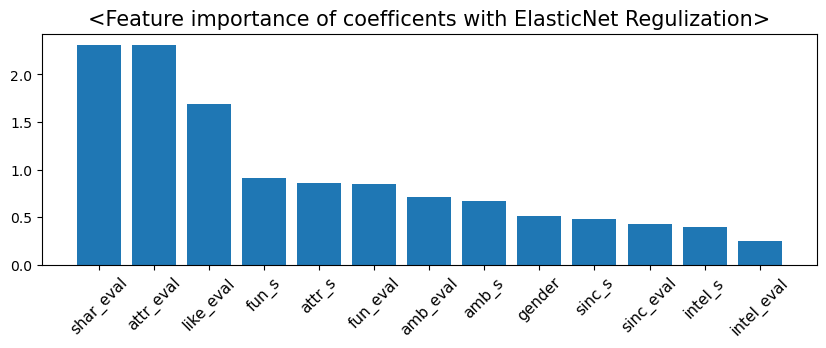

In [8]:
coef = np.abs(ElasticNet_coef)
coef = pd.Series(coef, index=X.columns).sort_values(ascending=False)
coef
# 시각화
plt.figure(figsize=(10,3))
plt.title('<Feature importance of coefficents with ElasticNet Regulization>', fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);

##### 독립변수가 여러 개일 때 모델의 성능을 시각화하려면 실제값과 예측값의 분포 차이를 그린다.
- 실제값과 예측값이 같을수록 x,y가 같은 곳을 찍어서 y = x 그래프를 그리게 될 것이다.

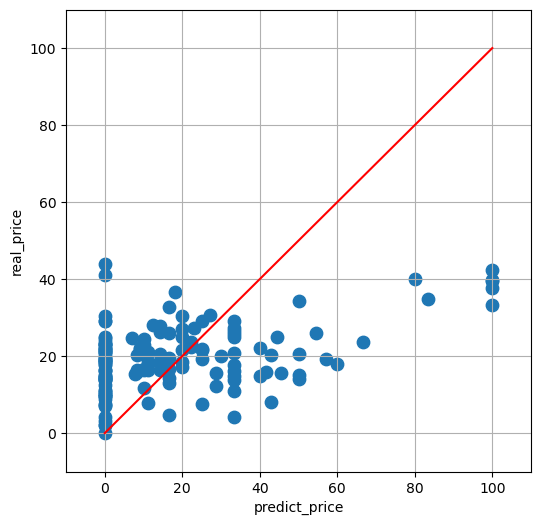

In [9]:
plt.figure(figsize = (6,6))
plt.scatter(y_test,y_pred,s = 80)
plt.grid()
plt.ylabel('real_price')
plt.xlabel('predict_price')
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.plot([0,100],[0,100],c = 'r')
plt.show()

### 변수 간의 상관관계를 히트맵으로 시각화 및 탐색

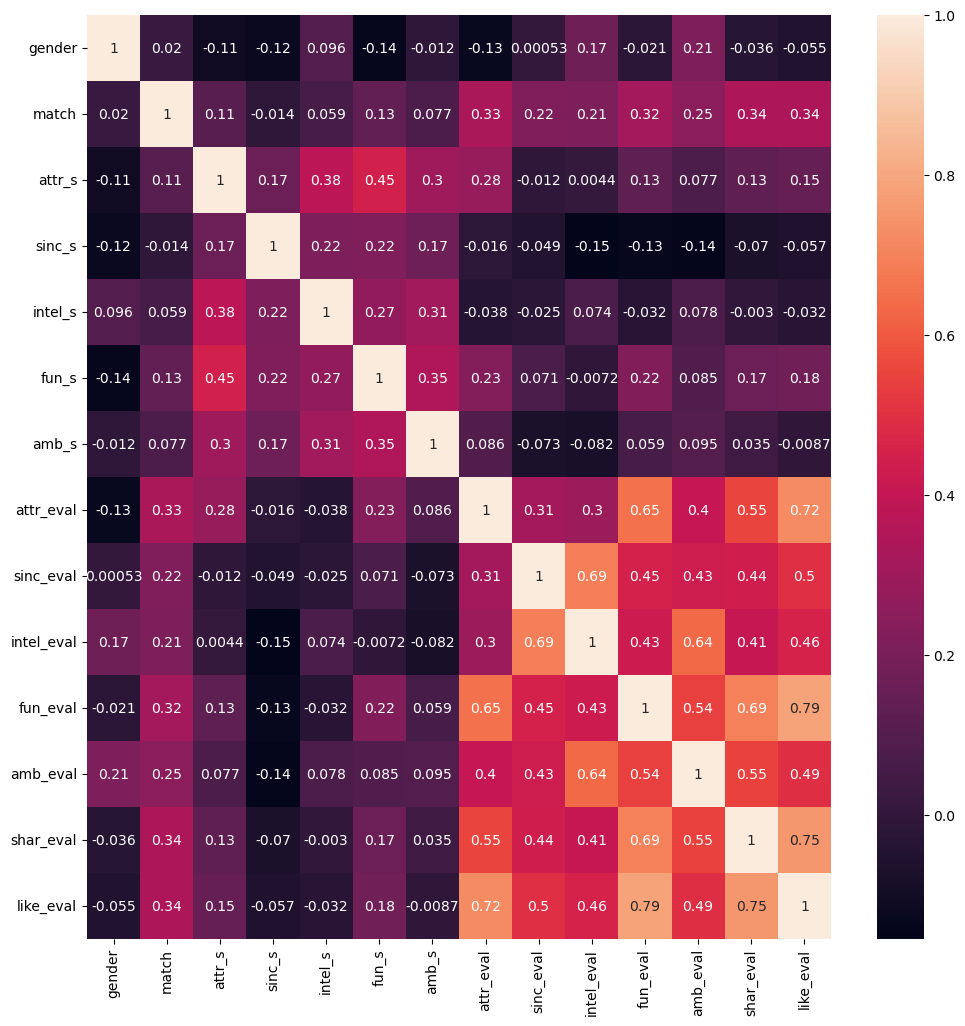

In [10]:
# 상관계수를 구하여 저장
corr_df = train.corr()
corr_df.corr()

# 상관계수를 히트맵으로 시각화
import seaborn as sns
plt.figure(figsize = (12,12))
sns.heatmap(corr_df, annot=True);

### 예측값

In [11]:
y_pred = grid.predict(X_test)
y_pred[y_pred < 0] = 0.

print("Predictions: ", y_pred)

Predictions:  [18.79671621 15.68646458 14.64756834 29.03761174 16.47939931 37.74591623
 20.977625   19.72186407 34.18843863 23.98922591  7.57161666 11.67012801
 27.85995031 22.14929749 19.60758424  8.0785271   2.01400891 24.9259314
 22.45087777 12.34007948 17.83337968 42.25405419 26.35501683 11.00427478
 17.0699532  20.08265186 43.94483298 15.10113093 21.40434504 21.08176494
 14.03014322 36.57038409 25.60963283 21.76080228 21.75159588 10.21177001
 12.95507093 27.26010529 23.64380733 10.98142306 27.20223753 10.05692502
  9.63307694 25.94380586 28.0833206  15.77055225  7.3276164  20.22557704
 21.93557015 27.15401451 17.85153726 19.00186895 16.4417088  26.0665461
  7.11713159 20.17844036 14.84684138 17.67779066 20.71975832  1.9867979
 19.22506155 17.86999467 14.29590533 14.78500614 22.05838286 30.55591771
 23.24270846 10.58139386 29.20908964 19.59324456 16.33406978 18.40121099
 16.68178571 14.72523431 13.9970259  23.08149126 21.59594361 16.29935521
 26.52905995  9.72024481 20.44952378 18.